<a href="https://colab.research.google.com/github/lcvicente/desafio_bndes/blob/main/01_pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-processamento dos datasets para entrada nos modelos de ML:


1.   Contratos de Banco de Serviços - https://dadosabertos.bndes.gov.br/group/ ->
     Download, OCR, clusterização e tratamento do texto dos contratos; 


2.   Contratos de Operações de Financiamento não Automáticas - https://dadosabertos.bndes.gov.br/dataset/operacoes-financiamento -> tratamento dos texto de descrição dos contratos

In [1]:
!python -m pip install pdf2image
!sudo apt-get install poppler-utils
!python -m pip install pillow
!sudo apt-get install tesseract-ocr-por
!python -m pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 1s (215 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend

In [10]:
# Leitura e proccessamento de imagens  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input
from pdf2image import convert_from_path
import pytesseract
from pytesseract import Output
from PIL import Image

# Modelos 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# Clusterização e diminuição de dimensionalidade
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Processamento de texto
import nltk
import string, re
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

# Outras Bibliotecas
import os
import numpy as np
import pandas as pd
import requests, zipfile, io
import glob
import matplotlib.pyplot as plt
from random import randint
import warnings
import re
warnings.filterwarnings('ignore')

np.random.seed(0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Comandos para rodar o programa utilizando o google drive como repositório
from google.colab import drive

drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/BNDES/'
try:
  os.chdir(workdir_path)
except:
  os.mkdir(workdir_path)
  os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## A sessão de código abaixo é para ser executada apenas caso de não for utilizar o google drive como repositório. Descomente os comandos.

In [8]:
'''
import os

workdir_path = 'Dataset/'
try:
  os.chdir(workdir_path)
except:
  os.mkdir(workdir_path)
  os.chdir(workdir_path)
'''

"\nimport os\n\nworkdir_path = 'Dataset/'\ntry:\n  os.chdir(workdir_path)\nexcept:\n  os.mkdir(workdir_path)\n  os.chdir(workdir_path)\n"

# Leitura e Pré-processamento dos dados

##### Funções para Limpeza dos Dados

In [5]:
# Remoção de todas as palavras com números
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)

# Remoção de pontuação
punc = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x)

# Remoção de palavras menores que 3 caracteres
remove_tres = lambda x: re.sub(r'\b\w{1,3}\b', '', x)

# Remoção de StopWords
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    stopwords += ['bndes','outros','contrato','anexo','contratação','servicos','tecnicos','necessarios','empresas','sistemas','classificacao','documento',
                'termo','referencia','edital','deste','projeto','projetos','conforme','anexos','denominados','proposta','contratado','apresentada']
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

##### Função para vetorização das palavras utilizando TF-IDF - 

## Banco de Serviços 

#### Estatísticas da atuação do BNDES como Banco de Serviços - Análise do objeto dos contratos https://dadosabertos.bndes.gov.br/group/desestatizacao  ->  Criação de DataFrame com o texto do objeto dos Contratos



##### Download dos contratos - coluna '**link_projeto**' do dataset 'banco-servicos-banco-de-servicos.csv'

In [7]:
# Leitura do dataset
file_banco_servico = 'https://dadosabertos.bndes.gov.br/dataset/432a6016-5b15-4b64-ae9a-8bbad2424625/resource/41fa7478-92d5-4206-aa10-f45eecf32eec/download/banco-servicos-banco-de-servicos.csv'
df = pd.read_csv(file_banco_servico, sep=';', decimal=',', encoding='UTF-8')

In [12]:
# Download e descompactação dos contratos do Banco de Serviços
lista_projetos = df['link_projeto'].to_list()
for i in range(len(lista_projetos)):
    r = requests.get(lista_projetos[i])
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('contratos')

In [13]:
# Selecionar pdfs de contratos

p = '^((?!(aditivo|anexos|carta)).)*$'
pdf_path = glob.glob('contratos/*')
pdf_contratos = [doc for doc in pdf_path if ('contrato' in doc.split('\\')[-1].lower() and re.match(p, doc.split('\\')[-1].lower()) != None)]

##### Transformação dos pdf em imagens

In [14]:
# Tranformação dos pdfs de contratos em imagems
os.makedirs('imagens/')
for i in range(len(pdf_contratos)):
    pages = convert_from_path(pdf_contratos[i], last_page=3)
    for j in range(len(pages)):
      page = pages[j]
      page.save('imagens/' + os.path.basename(pdf_contratos[i]).split('.')[0] + '_{}.png'.format(j), 'PNG')

##### Clusterização dos contratos de acordo com o template do documento

In [15]:
# Selecionar primeira página de cada contrato
imagem_contratos = glob.glob('imagens/*_0.png')

# Carregar a Rede Neural VGG16 pré-treinada para extração de características de cada imagem
model = VGG16(weights="imagenet")
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

# Funcão para extração de características de cada imagem
def extract_features(file, model):
    # carrega a imagem como array 224x224
    img = load_img(file, target_size=(224,224))
    # converte de 'PIL.Image.Image' para numpy array
    img = np.array(img) 
    # redimensiona os dados para input no modelo - reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepara a imagem para o modelo
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

553476096/553467096 [==============================] - 3s 0us/step


In [16]:
data = {}
# Loop através de cada imagem do dataset
for imagem in imagem_contratos:
    # Extrai características da imagem e atualiza o dicionário data
    try:
        feat = extract_features(imagem,model)
        data[imagem] = feat
    except:
        continue
          
 
# lista com o nome dos arquivos
filenames = np.array(list(data.keys()))

# lista com as características
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# Redimensionamento
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

(210, 4096)

In [17]:
# PCA para reduzir as dimensões do vetor de características
pca = PCA()
pca.fit(feat)
x = pca.transform(feat)

In [18]:
# Agrupar os vetores de características em n clusters -> melhor número encontrado n_clusters=3
agg = AgglomerativeClustering(n_clusters=5)
agg.fit(x)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

In [19]:
# Cria dicionário { id: [images] }
groups = {}
for file, cluster in zip(filenames, agg.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

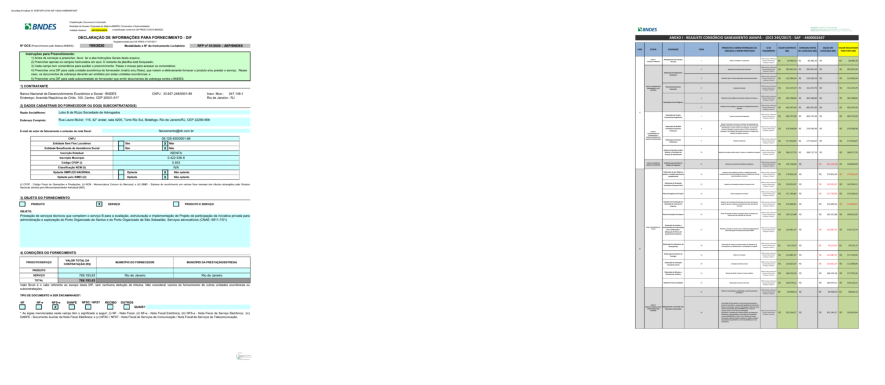

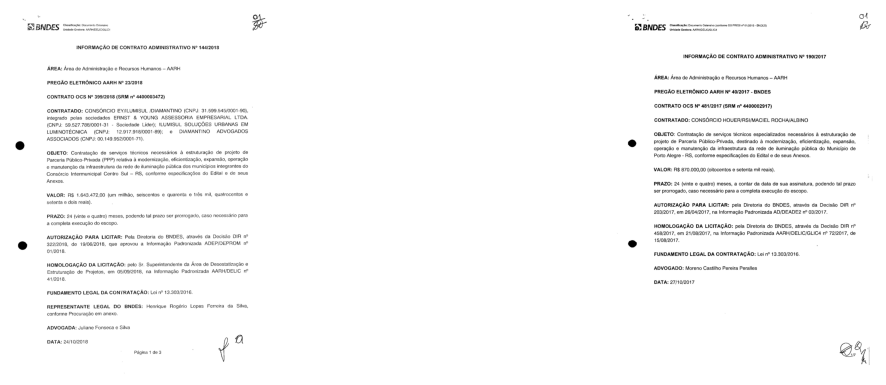

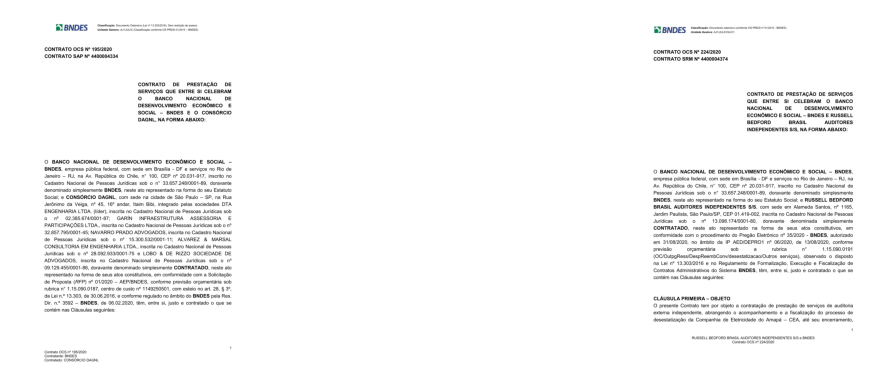

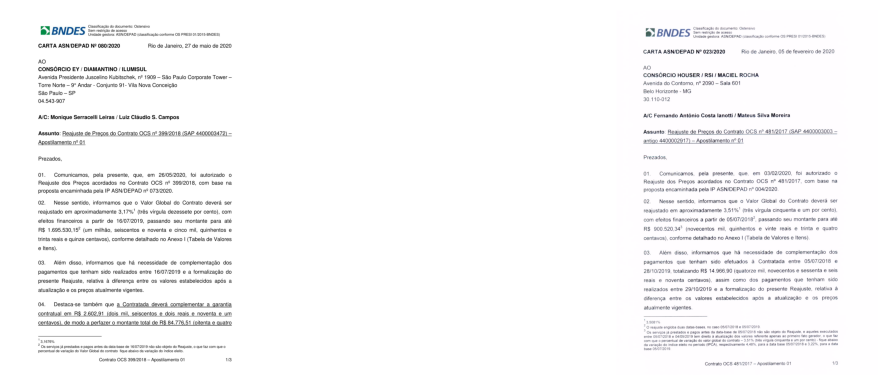

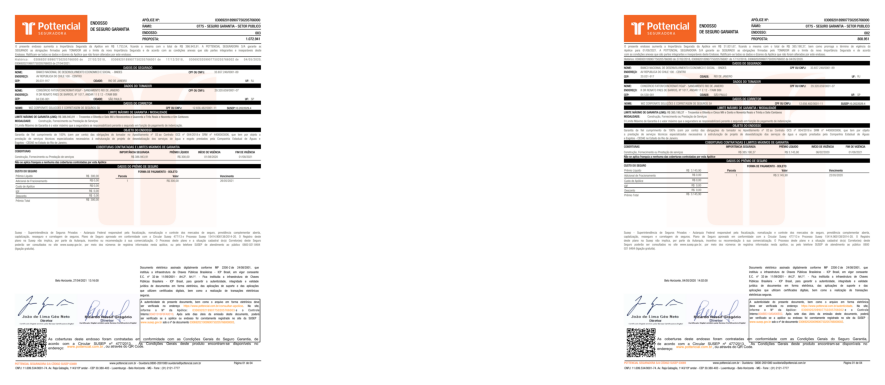

In [20]:
# Mostra 2 imagens de cada cluster        
for i in range(len(groups)):
    plt.figure(figsize = (20,15));
    # lista com o nome dos arquivos de cada grupo
    files = groups[i]
    # mostra somente 2 imagens por grupo
    first_images = files[:2]
    for index, file in enumerate(first_images):
        #print(f'Group {i}')
        plt.subplot(2,2,index+1);
        img = plt.imread(file)
        img = np.array(img)
        plt.imshow(img,cmap='gray')
        plt.axis('off'); 

##### Criação de dataframe com o texto do objeto dos contratos 

In [21]:
# Processamento das imagens com o Tesseract - OCR
for key in groups:
    df2 = pd.DataFrame()
    texto = dict()
    lista_imagens_0 = groups[key]
    lista_imagens_1 = []
    for imagem in lista_imagens_0:
        imge = imagem.replace('_0', '_1')
        lista_imagens_1.append(imge)
    lista_imagens = lista_imagens_0 + lista_imagens_1
    for i in range(len(lista_imagens)):
        try:
            texto['X'+str(i)] = pytesseract.image_to_data(lista_imagens[i], lang ='por', output_type=Output.DICT)
            d = pd.DataFrame(texto['X'+str(i)])
            df2 = df2.append(d, ignore_index=True)
        except:
            continue

    # remover valores nulos
    df2.dropna(subset=['text'],inplace=True)

    # Retirar palavras com confiânça menos que 80%
    df3 = df2[pd.to_numeric(df2['conf']) > 80]

# Selecionar o texto referente aos contratos de cada grupo
    
    # Cluster #0
    if key == 0:
        texto0 = ' '.join(df3['text']).lower()
        start_sep='tem por objeto '
        end_sep=' cláusula segunda '    
        t0=[]
        tmp=texto0.split(start_sep)
        for par in tmp:
          if end_sep in par:
            t0.append(par.split(end_sep)[0])

    # Cluster #1
    elif key == 1:
        texto1 = ' '.join(df3['text']).lower()        
        start_sep='objeto: '
        end_sep='valor: ' 
        t1=[]
        tmp=texto1.split(start_sep)
        for par in tmp:
          if end_sep in par:
            t1.append(par.split(end_sep)[0]) 

    # Cluster #2
    elif key == 2:
        texto2 = ' '.join(df3['text']).lower()   
        start_sep='tem por objeto '
        end_sep='objetivos e diretrizes'     
        t2=[]
        tmp=texto2.split(start_sep)
        for par in tmp:
          if end_sep in par:
            t2.append(par.split(end_sep)[0])
   
    # Clusters #3 e #4-- A análise dos documentos desses clusters mostrou que podemos descartá-los
    elif (key == 3) or (key == 4):
        continue


texto_contrato = t0 + t1 + t2
df_bs = pd.DataFrame(texto_contrato, columns = ['texto'])

In [22]:
# Remoção de acentos
df_bs.texto = df_bs.texto.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [23]:
# Pré-processamento do texto
df_bs.texto = df_bs.texto.map(alphanumeric).map(punc).str.lower().map(remove_tres).map(remove_stopwords)

In [24]:
# Salvar dataset para utilização nos modelos de ML
df_bs.to_csv('contratos_bs.csv', index=True, sep=';', encoding='UTF-8')

## Operações de Financiamento não Automáticas
#### Leitura de DataFrame

##### Dados detalhados das condições das operações de financiamento contratadas, incluindo condições de financiamento, porte do cliente e produto contratado. https://dadosabertos.bndes.gov.br/dataset/operacoes-financiamento

In [25]:
# Leitura do dataset
file_op_nao_aut = 'https://dadosabertos.bndes.gov.br/dataset/0f335c85-92a8-4343-9423-f073fb40774e/resource/332d446e-d340-46ef-af64-ee6f36e7bd50/download/operacoes-financiamento-operacoes-nao-automaticas.csv'
df_ofna = pd.read_csv(file_op_nao_aut, decimal= ',', sep=';', encoding='UTF-8')

In [26]:
# Remover valores nulos
df_ofna.dropna(subset=['descricao_do_projeto'],inplace=True)

In [27]:
# Remoção de acentos
df_ofna.descricao_do_projeto = df_ofna.descricao_do_projeto.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [28]:
# Pré-processamento do texto
df_ofna.descricao_do_projeto = df_ofna.descricao_do_projeto.map(alphanumeric).map(punc).str.lower().map(remove_tres).map(remove_stopwords)

In [29]:
# Salvar dataset para utilização nos modelos de ML
df_ofna.to_csv('contratos_ofna.csv', index=True, sep=';', encoding='UTF-8')

# Pré-processamento dos conjunto de dados realizados. Execute o script LDA_WordCloud.ipynb

## Os seguintes arquivos foram gerados neste pré_processamento:
### contratos_bs.csv   ---> Dados dos arquivos de contratos em formato de PDF
### contratos_ofna.csv ---> Dados do repositório de dados de Operações de financiamento não automáticas